# Imports

In [1]:
import numpy as np
import matplotlib.image as mpimg
import scipy as sci
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline
from os import listdir
from os.path import isfile , join
from scipy import misc
from scipy import signal
import cv2
import CV404Filters as flt
import math

# General Functions

In [2]:
def gray_scale(img):
    r = img[:,:,0] * 0.2989 
    g = img[:,:,1] * 0.5870 
    b = img[:,:,2] * 0.1140
#     r = img[:,:,0] / 3
#     g = img[:,:,1] / 3
#     b = img[:,:,2] / 3
    return np.add(r, g, b)

In [3]:
def show_images_fast(images):
    fig = plt.figure(figsize=(20, 8))
    for i in range(0, len(images)):
        ax = fig.add_subplot(2, 3, i + 1)
        plt.axis("off")
        plt.imshow(images[i], cmap=plt.get_cmap('gray'))


# Read Images

In [4]:
images_files = [ join("./images" , f) for f in listdir("images") if isfile(join("images" , f)) ]
#print(images_files)
#print(listdir("images"))
rgbImages = [ mpimg.imread( f ) for f in images_files ]

In [5]:
grayImg = [ gray_scale(img) for img in rgbImages ]

IndexError: too many indices for array

# Canny

In [6]:
def canny_edge_detection(input):
    
    input = input.astype('uint8')

#     # Using OTSU thresholding - bimodal image
    otsu_threshold_val, ret_matrix = cv2.threshold(input,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    #lower_threshold = otsu_threshold_val * 0.8
    #upper_threshold = otsu_threshold_val * 1.7
    
    upper_threshold = otsu_threshold_val
    lower_threshold = upper_threshold * 0.1
    
    
    print(lower_threshold,upper_threshold)
#     lower_threshold = 255/3
#     upper_threshold = 255
    #print(lower_threshold,upper_threshold)
    edges = cv2.Canny(input,lower_threshold,upper_threshold)
    return edges

In [7]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    image_blur = cv2.GaussianBlur(image,(11,11),1)
#     image_blur = flt.gaussian_filter(image, sigma = 1.0, kernelSize = 11)
    edged = cv2.Canny((image_blur).astype(np.uint8), lower, upper)
    indices = np.where(edged != [0])
#     coordinates = list(zip(indices[0], indices[1]))
    co = np.vstack((indices)).T
    # return the edged image
    return edged
# detected_edges = cv2.Canny(img_blur, low_threshold, low_threshold*ratio, kernel_size)
# ratio = 3
# kernel_size = 3
# low_threshold = val

In [8]:
ratio = 3
kernel_size = 3
def CannyThreshold(val,img):
    low_threshold = val
    img_blur = cv2.blur(img, (3,3))
    detected_edges = cv2.Canny(img_blur, low_threshold, low_threshold*ratio, kernel_size)
    return detected_edges

# Hough Line

## Accumulator Building

In [9]:
def hough_lineA(image):
 
    Ny = image.shape[0]
    Nx = image.shape[1]
    edge,coo = auto_canny(image)
    Maxdist = int(np.round(np.sqrt(Nx**2 + Ny ** 2)))


    thetas = np.deg2rad(np.arange(-90, 90))
    rs = np.linspace(-Maxdist, Maxdist, 2*Maxdist)

    accumulator = np.zeros((2 * Maxdist, len(thetas)))

    for y in range(Ny):
        for x in range(Nx):

            if image[y,x] > 0:
  
                 for k in range(len(thetas)):

                    r = x*np.cos(thetas[k]) + y * np.sin(thetas[k])

                    accumulator[int(r) + Maxdist,k] += 1
    return accumulator, thetas, rs

In [10]:
def hough_space(image, thetaRes = 1, rhoRes = 1): 
    
    #RhoRes in degrees
    
    Ny = image.shape[0] # rows
    Nx = image.shape[1] # columns
       
    maxRho = math.hypot(Nx, Ny)
    
    #Check resolution values
    if not(0 < thetaRes < 90):
        print('error please input a correct step for theta')
        return
        
    elif not(0 < rhoRes < maxRho):
        print('error please input a correct step for rho')
        return
    else:

#         #Check its gray and do canny
#         if len(image.shape) == 3 :
#             greyImg = gray_scale(image)
#         else:
#             greyImg = image
#         edgeImg, edgeCoordinates = auto_canny(greyImg) ####PROBLEM WITH CANNY
        
        # 1. initialize parameter space rs, thetas
        
        ## Theta in range from -90 to 90 degrees with step of thetaRes
        thetas = np.deg2rad(np.arange(-90.0, 90, thetaRes, dtype = float))
        thetasLen = len(thetas)
        
        sinang = dict() 
        cosang = dict() 
        for angle in range(thetasLen): 
            sinang[angle] = np.sin(angle) 
            cosang[angle] = np.cos(angle)
        
        ## Range of radius
        rhos = np.arange(-maxRho, maxRho, rhoRes, dtype = float)
        rhosLen = len(rhos)
        
        #2. Create accumulator array and initialize to zero
        accumulator = np.zeros((rhosLen, thetasLen))

        for y in range(Ny):
            for x in range(Nx):
                if image[y,x] > 0:
                    for k in range(thetasLen):
                        try:
#                             r = x * np.cos(thetas[k]) + y * np.sin(thetas[k])
                            r = x * cosang[k] + y * sinang[k]
                            ir = r/rhoRes 
                            if r >= 0:
                                accumulator[int(ir - rhosLen//2-1),k] += 1
                            else:
                                accumulator[int(ir + rhosLen//2-1),k] += 1
                        except IndexError:
                            pass
        return accumulator, thetas, rhos

In [11]:
np.ceil(0.2)

1.0

## Finding peaks in hough space

In [12]:
import scipy.ndimage.filters as filters

In [13]:
def hough_peaks(accumulator, numPeaks, thresh = None, nHoodSize = None):
    if numPeaks == None:
        numPeaks = 1
    if thresh == None:
        thresh = 0.5 * accumulator.max()
    if nHoodSize == None:
        y = int (np.ceil(accumulator.shape[0]/50))
        x = int (np.ceil(accumulator.shape[1]/50))
        if y % 2 != 0:
            y = y + 1
        if x % 2 != 0:
            x = x + 1
        nHoodSize = [y,x]
        #check neighbourhood size is tuple and odd
#     else:
#         if 
    done = False
    row = []
    col = []
    newHough = accumulator.copy()
    while not done:
        hough_max = np.amax(newHough) 
#         print(hough_max)
        max_indices = np.where(newHough == hough_max)
        p = max_indices[0][0]
        q = max_indices[1][0]
        if newHough[p, q] >= thresh:
            row.append(p)
            col.append(q)
            p1 = int(p - (nHoodSize[0] - 1)/2 )
            p2 = int( p + (nHoodSize[0] - 1)/2)
            q1 = int(q - (nHoodSize[1] - 1)/2)
            q2 = int(q + (nHoodSize[1] - 1)/2)
            pp,qq = np.mgrid[p1:p2, q1:q2]
            pp = np.ravel(pp,'F')
            qq = np.ravel(qq,'F')
#             badrho = np.where((pp.any() < 0) or (pp.any() > accumulator.shape[0]))
#             pp = np.delete(pp, badrho)
#             qq = np.delete(qq, badrho)
#             theta_too_low = np.where(qq.any() < 0)
#             qq[theta_too_low] = accumulator.shape[1] + qq[theta_too_low]
#             pp[theta_too_low] = accumulator.shape[0] - pp[theta_too_low] + 1
#             theta_too_high = np.where(qq.any() > accumulator.shape[1])
#             qq[theta_too_high] = qq[theta_too_high] - accumulator.shape[1]
#             pp[theta_too_high] = accumulator.shape[0] - pp[theta_too_high] + 1
            gridCoordinates = list(zip(pp,qq))
            for i in range(len(gridCoordinates)):
                newHough[gridCoordinates[i]] = 0.0
#                 print(newHough[gridCoordinates[i]])
            done = (len(row) == numPeaks)
        else:
            done = True
    return row, col, newHough

## Extract lines

In [14]:
a = np.array([[1, 2, 3], [4, 5, 6]]) 
  
print(a) 
  
print ('Indices of elements <4') 
  
x, y = np.where(a<4) 
print(x, y) 
  
print("Elements which are <4") 
print(a[x,y]) 

[[1 2 3]
 [4 5 6]]
Indices of elements <4
[0 0 0] [0 1 2]
Elements which are <4
[1 2 3]


In [15]:
a = np.array([1, 2, 3]) 
b = np.array([1, 2, 3]) 
n = np.vstack((a,b)).T
phi = np.deg2rad((90 - 0))
cos = np.cos(phi)
sin = np.sin(phi)
matrix = [[cos, sin ], [-sin, cos]]
v = np.matmul(n, matrix)
q = np.sort(v[:,1])
# print(v,q)
print(np.concatenate((a,b), axis=0))

[1 2 3 1 2 3]


In [16]:
a = np.array([1, 2, 3]) 
np.append(a,np.inf)

array([ 1.,  2.,  3., inf])

In [17]:
from collections import defaultdict
def extract_lines( accumulator , thetas , rhos, row, col) :
    lines = defaultdict()
    acc2 = np.zeros(accumulator.shape)
    for i in range(len(row)):
        for j in range(len(col)):
            theta = thetas[col[j]]
            rho = rhos[row[i]]
            # print (angle , rho , accumulator[angle_index , rho])
            lines[(rho,theta)] = accumulator[row[i], col[j]]
            acc2[row[i], col[j]] = accumulator[row[i], col[j]]
    return lines,acc2


def show_lines( img, accumulator , thetas , rhos, row, col ):
    lines_img2, acc2_img2 = extract_lines( accumulator , thetas , rhos, row, col ) 
    
    fig = plt.figure(figsize=(20,20))    
    gs = fig.add_gridspec(2,2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, :])

    
    
    limits = [rhos[0], rhos[-1], np.rad2deg(thetas[0]), np.rad2deg(thetas[-1])]
    ax1.set_title('Hough Space')
    ax1.imshow(accumulator, aspect='auto', extent= limits, cmap=cm.hot,interpolation='bilinear' )
    ax1.set_ylabel('Theta')
    ax1.set_xlabel('Rho')
    ax1.set_title('Hough')
    
    ax2.set_title('Hough Space (Processed)')
    ax2.imshow(acc2_img2, aspect='auto', extent= limits, cmap=cm.hot,interpolation='bilinear' )
    ax2.set_ylabel('Theta')
    ax2.set_xlabel('Rho')
    
    im = ax3.imshow( img, cmap='gray' )
    ax3.set_title('Original Image /w lines')
    ax3.autoscale(False)
    
    for (rho,theta), val in lines_img2.items():
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        ax3.plot((x0,x1), (y0, y1), '-r')

    plt.show()
    

## Simple images trial without canny

In [18]:
pointsCheck = np.zeros((101 , 101))
pointsCheck[100][100] = 1
pointsCheck[50][50] = 1
pointsCheck[0][0] = 1
pointsCheck[100][0] = 1
pointsCheck[0][100] = 1


In [19]:
image_2l = np.zeros((150,150))
image_2l[np.linspace(0,120,100).astype(int), np.linspace(120,0,100).astype(int)] = 1
image_2l[np.linspace(20,80,100).astype(int), np.linspace(0,120,100).astype(int)] = 1

In [ ]:
import CV404Filters as fn

In [ ]:
i = cv2.GaussianBlur(imgs[0],(11,11),1)
e = cv2.Canny(i.astype(np.uint8),100,200)
# e = fn.canny_edge(imgs[1], sigma = 0.1, gaussSize = 11, minThresh = 10, maxThresh = 50)

In [ ]:
plt.imshow(e, cmap = 'gray')

In [20]:
accumulator_1l, thetas_1l, rhos_1l = hough_space(image_2l,1, 1)

In [21]:
np.amax(accumulator_1l)

100.0

In [22]:
row,col,nhough = hough_peaks(accumulator_1l,5)

In [ ]:
accumulator_1l.shape

In [ ]:
print(row,col)

In [ ]:
n = np.vstack((row,col)).T
n[0]

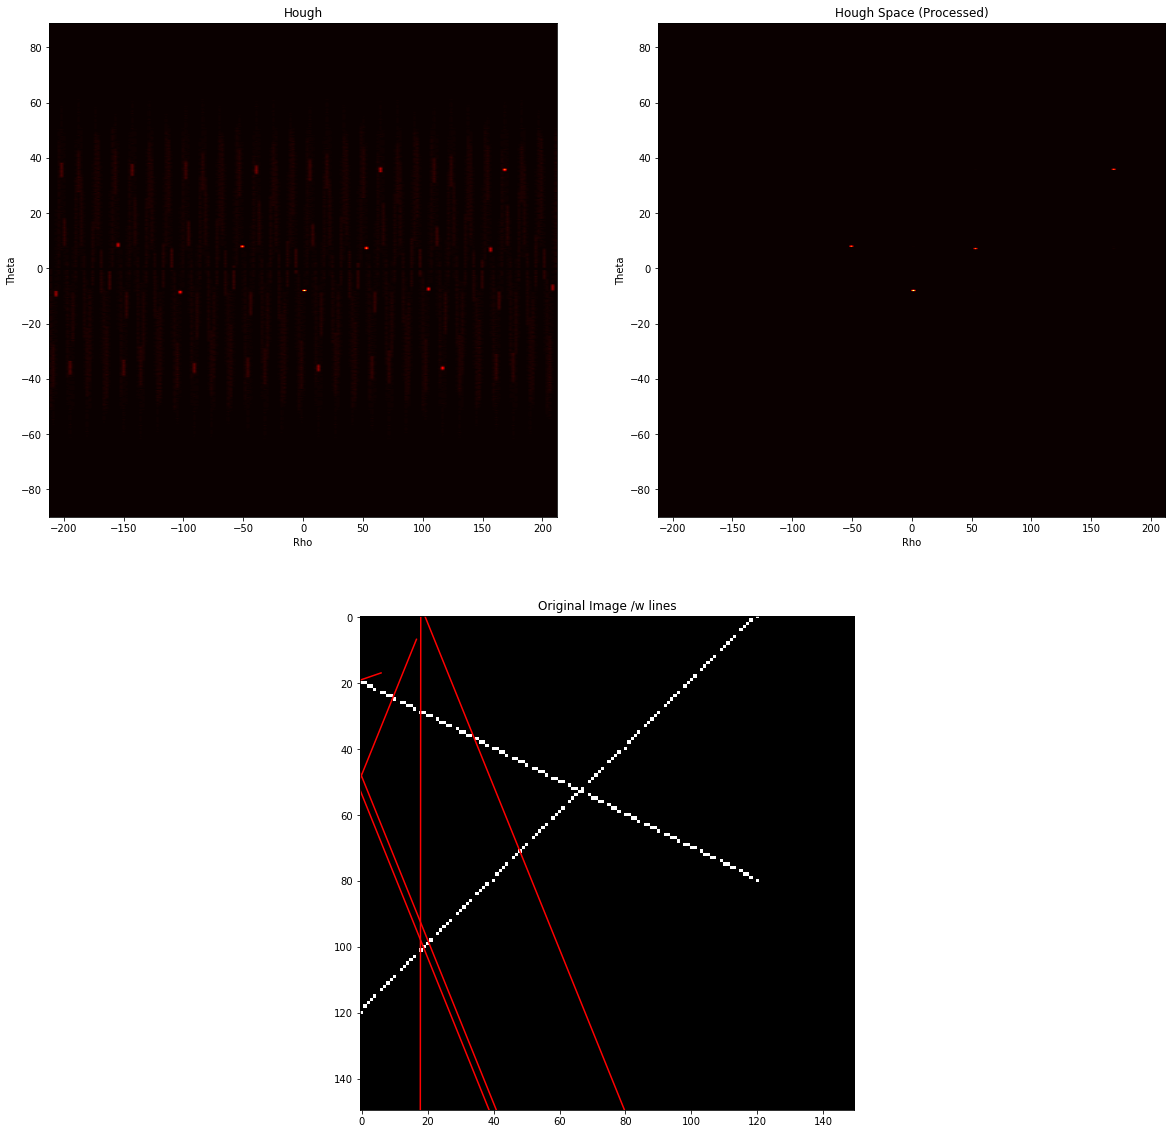

In [23]:
show_lines(image_2l, accumulator_1l , thetas_1l , rhos_1l, row, col )


In [ ]:


plt.set_cmap('seismic')

fig, ax = plt.subplots(1,2,figsize = (15, 10))
ax[0].set_title('Original Image')
ax[0].imshow(image_2l,cmap=cm.hot,interpolation='bilinear')

ax[1].set_title('Hough Space')
limits = [ np.rad2deg(thetas_1l[0]), np.rad2deg(thetas_1l[-1]), rhos_1l[0], rhos_1l[-1]]
ax[1].imshow(accumulator_1l, aspect='auto', extent= limits ,cmap=cm.hot,interpolation='bilinear')
ax[1].set_ylabel('Rho')
ax[1].set_xlabel('Theta')

plt.show()

# Hough Circle

In [24]:

def detectCircles(img,threshold,region,radius = None):
    (M,N) = img.shape
    if radius == None:
        R_max = np.max((M,N))
        R_min = 3
    else:
        [R_max,R_min] = radius

    R = R_max - R_min
    #Initializing accumulator array.
    #Accumulator array is a 3 dimensional array with the dimensions representing
    #the radius, X coordinate and Y coordinate resectively.
    #Also appending a padding of 2 times R_max to overcome the problems of overflow
    A = np.zeros((R_max,M+2*R_max,N+2*R_max))
    B = np.zeros((R_max,M+2*R_max,N+2*R_max))

    #Precomputing all angles to increase the speed of the algorithm
    theta = np.arange(0,360)*np.pi/180
    edges = np.argwhere(img[:,:])                                               #Extracting all edge coordinates
    for val in range(R):
        r = R_min+val
        #Creating a Circle Blueprint
        bprint = np.zeros((2*(r+1),2*(r+1)))
        (m,n) = (r+1,r+1)                                                       #Finding out the center of the blueprint
        for angle in theta:
            x = int(np.round(r*np.cos(angle)))
            y = int(np.round(r*np.sin(angle)))
            bprint[m+x,n+y] = 1
        constant = np.argwhere(bprint).shape[0]
        for x,y in edges:                                                       #For each edge coordinates
            #Centering the blueprint circle over the edges
            #and updating the accumulator array
            X = [x-m+R_max,x+m+R_max]                                           #Computing the extreme X values
            Y= [y-n+R_max,y+n+R_max]                                            #Computing the extreme Y values
            A[r,X[0]:X[1],Y[0]:Y[1]] += bprint
        A[r][A[r]<threshold*constant/r] = 0

    for r,x,y in np.argwhere(A):
        temp = A[r-region:r+region,x-region:x+region,y-region:y+region]
        try:
            p,a,b = np.unravel_index(np.argmax(temp),temp.shape)
        except:
            continue
        B[r+(p-region),x+(a-region),y+(b-region)] = 1

    return B[:,R_max:-R_max,R_max:-R_max]


In [25]:
def hough_circle(img, thresh, nHood):
    Ny = img.shape[0] # rows
    Nx = img.shape[1] # columns
    
#     maxRho =  int(np.round(math.hypot(Nx, Ny)))
    thetas = np.deg2rad(np.arange(0, 360))
    maxRho = np.max((Ny,Nx))
    thetasLen = len(thetas)
    rs = np.arange(1, maxRho, 1)
    
    sinang = dict() 
    cosang = dict() 
    for angle in range(thetasLen): 
        sinang[angle] = np.sin(angle) 
        cosang[angle] = np.cos(angle)
    
    edges = np.argwhere(img[:,:])
    accumulator = np.zeros((maxRho,Ny,Nx))
    
    for r in range(len(rs)): 
        for x in range(Nx):
            for y in range(Ny):
                if img[y,x] > 0 :
                    for k in range(thetasLen):
                        try:
                            a = y - rs[r] * cosang[k] 
                            b = x - rs[r] * sinang[k]
                            accumulator[int(np.round(r)), int(a), int(b)] += 1
                        except IndexError:
                            pass
        accumulator[r][accumulator[r] < thresh] = 0
    
#     for u in range(Nx):
#         for v in range(Ny):
#             if img[v,u] > 0 :
#                 for x in range(Nx):
#                     for y in range(Nx):
#                         r = np.sqrt((u-x)**2-(v-y)**2)
#                         try:
#                             a = y - rs[r] * cosang[k] 
#                             b = x - rs[r] * sinang[k]
#                             accumulator[int(np.round(r)), int(a), int(b)] += 1
#                         except IndexError:
#                             pass
#     accumulator[r][accumulator[r] < thresh] = 0
    
    
    
    circles = np.zeros((maxRho,Nx,Ny)) 
    for r,x,y in np.argwhere(accumulator):
        region = accumulator[r-nHood:r+nHood,x-nHood:x+nHood,y-nHood:y+nHood]
        try:
            p,cx,cy = np.unravel_index(np.argmax(region),region.shape)
        except:
            continue
        try:
            circles[r+(p-nHood),x+(cx-nHood),y+(cy-nHood)] = 1
        except IndexError:
            pass
    return circles


        

In [26]:
def display_circles(circles, img):
    fig = plt.figure()
    plt.imshow(img)
    circleCoordinates = np.argwhere(circles)                                
    circle = []
    for x,y,r in circleCoordinates:
        circle.append(plt.Circle((x,y),r,color=(1,0,0),fill=False))
        fig.add_subplot(111).add_artist(circle[-1])
    plt.show()


In [242]:
from PIL import Image
import numpy as np
from skimage.color import rgb2gray

cirImg = ['houghCircImages/conan.jpg', 'houghCircImages/coins1.jpg']
cirImgs_rgb = [ np.array(Image.open(img)) for img in cirImg ]
grCirImgs = [ gray_scale( img ) for img in cirImgs_rgb ]
cirBlurs = [cv2.GaussianBlur(img,(3,3),1) for img in grCirImgs]
cirEdgesOt = [cv2.Canny(img.astype(np.uint8),100,200) for img in cirBlurs]

i = cirEdgesOt[0]
f = cirImgs_rgb[0]

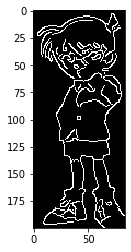

In [243]:
plt.imshow(i, cmap = 'gray')

In [218]:
grCirImgs[1].argmax()

205083

In [244]:
circles = detectCircles(i,8.1,15)

In [ ]:
circles = hough_circle(i, 30, 15)

In [238]:
from collections import defaultdict
from PIL import Image, ImageDraw
import matplotlib as mp


input_image = i
(M,N) = input_image.shape

 
# Find circles
rmin = 18
rmax = np.max((M,N))
steps = 100
threshold = 0.35

points = []
for r in range(rmin, rmax + 1):
    for t in range(steps):
        points.append((r, int(r * np.cos(2 * np.pi * t / steps)), int(r * np.sin(2 * np.pi * t / steps))))

acc = defaultdict(int)
for x, y in np.argwhere(i[:,:]):
    for r, dx, dy in points:
        a = x - dx
        b = y - dy
        acc[(a, b, r)] += 1

circles = []
for k, v in sorted(acc.items(), key=lambda i: -i[1]):
    x, y, r = k
    if v/steps >= threshold and all((x - xc) ** 2 + (y - yc) ** 2 > rc ** 2 for xc, yc, rc in circles):
        circles.append((x, y, r))




In [ ]:
sorted(acc.items(), key=lambda i: -i[1])

In [158]:
circles


[]

c:\users\merna\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


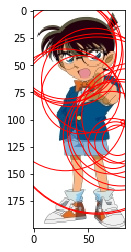

In [247]:
display_circles(circles,f )

In [29]:
circles.argmax()

0

In [7]:
a = np.array([[[1, 2, 3],
               [4, 5, 6],
               [6, 7, 8]],
             
               [[9, 10, 11],
                [12, 13, 14],
                [14, 16, 17]],
             [[18, 19, 20],
               [21, 22, 23],
             [24, 25,26]]])
a[0][a[0] < 5]=0
a

array([[[ 0,  0,  0],
        [ 0,  5,  6],
        [ 6,  7,  8]],

       [[ 9, 10, 11],
        [12, 13, 14],
        [14, 16, 17]],

       [[18, 19, 20],
        [21, 22, 23],
        [24, 25, 26]]])

# Code checks outside functions

In [ ]:
# img = auto_canny(grayImg[0])
# indices = np.where(img != [0])
# coordinates = list(zip(indices[0], indices[1]))
# for i in coordinates:
#     print(img[i])

In [ ]:
for i in range(len(coordinates)):
    print (coordinates[i])

In [ ]:
n = np.arange(-100, 100, 2, dtype = float)

In [ ]:
x = np.ceil(accumulator_1l.shape[0]/50)
y = np.ceil(accumulator_1l.shape[1]/50) 
if y % 2 == 0:
    y = y + 1
if x % 2 == 0:
    x = x + 1
print(x,y)

In [ ]:
hough_max = np.amax(accumulator_1l) 
max_indices = np.where(accumulator_1l == hough_max)
# print(max_indices[0][1])
p = max_indices[0][0]
q = max_indices[1][0]
r = []
c = []
r.append(p) 
c.append(q)
r.append(5)
print(hough_max)


In [ ]:
nHoodSize = [3,3]
p1 = int(p - (nHoodSize[0] - 1)/2 )
p2 = int(p + (nHoodSize[0] - 1)/2)
q1 = int(q - (nHoodSize[1] - 1)/2)
q2 = int(q + (nHoodSize[1] - 1)/2)

In [ ]:
pp,qq = np.mgrid[p1:p2+1, q1:q2+1]
pp= np.ravel(pp,'F')
qq= np.ravel(qq,'F')

In [ ]:
# print(pp,qq)
m = list(zip(pp,qq))
# print(m)
for i in range(len(m)):
    accumulator_1l[m[i]] = 0
for i in range(len(m)):
    print(accumulator_1l[m[i]])

In [ ]:
arr = np.array([pp,qq])
np.ravel_multi_index(arr, accumulator_1l.shape)

In [ ]:
accumulator_1l.shape

In [ ]:
b = np.where((pp < 0) | (pp > accumulator_1l.shape[0]))
np.delete(pp, b)

In [ ]:
ppp = np.ravel(pp,'F')
ppp

In [ ]:
np.where(accumulator_1l == np.amax(accumulator_1l))

In [ ]:
accumulator_1l.shape

# Test images

## Hough Line

In [27]:
from PIL import Image
import numpy as np
from skimage.color import rgb2gray
from skimage import feature

imgs = ['houghTestImages/Chess_Board.png', 'houghTestImages/chess.jpg', 'houghTestImages/Rodin_Burghers_of_Calais_0281.jpg', 'houghTestImages/emara.jpg', 'houghTestImages/hough check.jpg']
imCan = np.array(Image.open('houghTestImages/chessCan.png'))
imgs_rgb = [ np.array(Image.open(img)) for img in imgs ]
imgs = [ gray_scale( img ) for img in imgs_rgb ]

In [28]:
blurs = [cv2.GaussianBlur(img,(11,11),1) for img in imgs]
# edges = [canny_edge_detection(img) for img in imgs]
# blur = cv2.GaussianBlur(imgs[1],(11,11),1) 
edgesAc = [auto_canny(img) for img in imgs]
# edgesOc = [cv2.Canny((img).astype(np.uint8),25,75) for img in blurs] 
# edgesSc = [feature.canny(img, 3) for img in imgs]
# edgesOt = [canny_edge_detection(img) for img in blurs]

In [ ]:
imCan.shape

In [ ]:
np.where(edgesAc[0] != [0])

In [ ]:
np.vstack((np.where(edgesAc[0] != [0]))).T

In [ ]:
imgs[2][0]

In [ ]:
# hough_imgs = [  hough_line(img) for img in edges ]

In [29]:
hough_imgs = hough_space(edgesAc[3])

In [30]:
row,col,nhough = hough_peaks(hough_imgs[0], 10, thresh = 200)

In [ ]:
print(row,col)

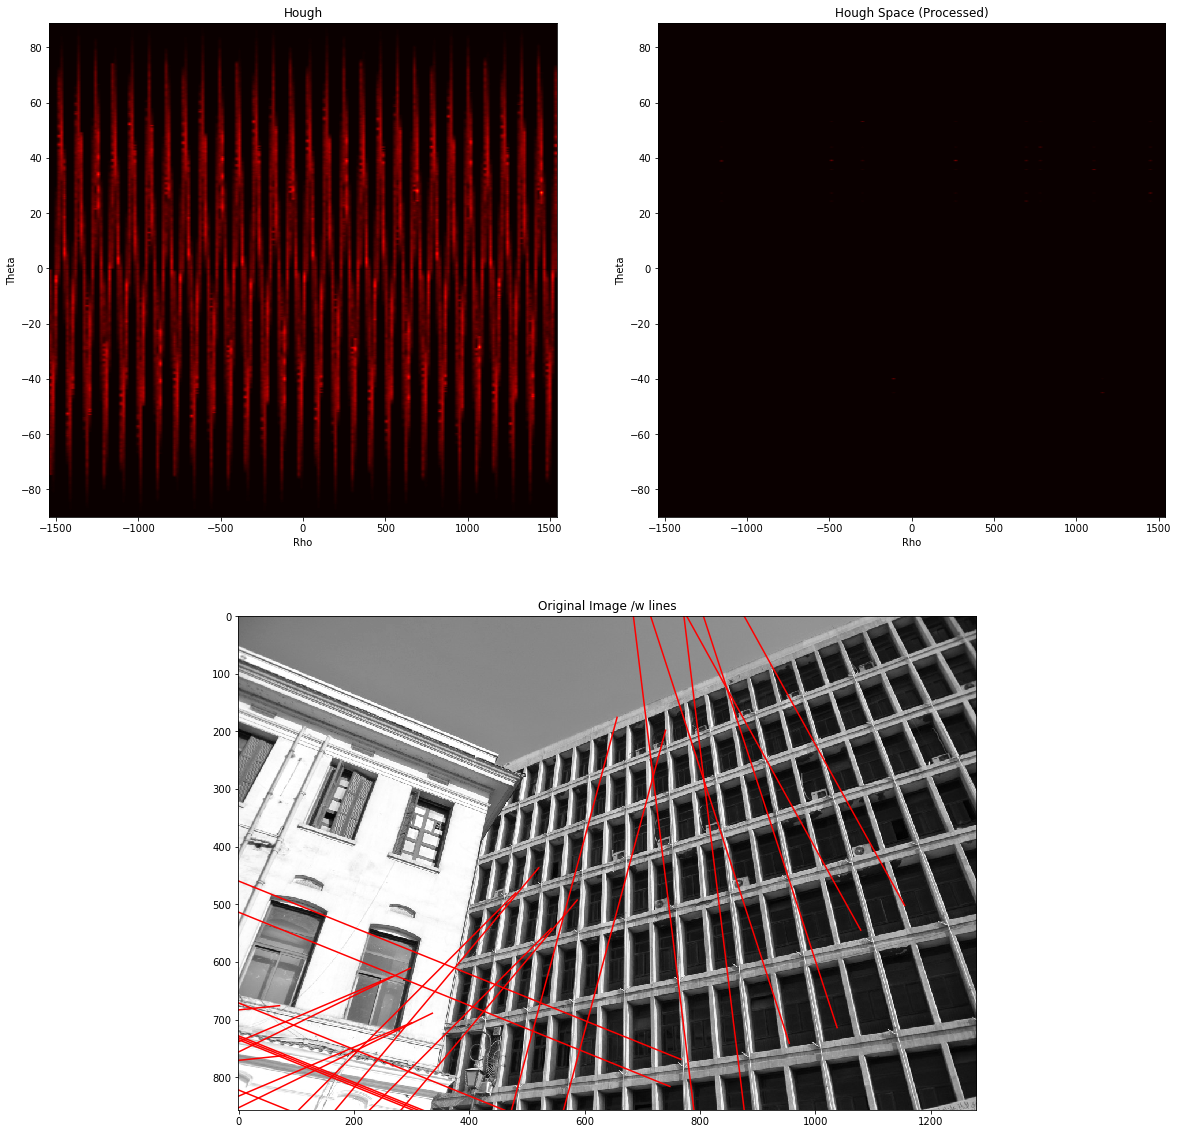

In [31]:
show_lines(imgs[3], hough_imgs[0] , hough_imgs[1] , hough_imgs[2], row, col )

In [ ]:
fig, ax = plt.subplots(len(imgs),3,figsize = (10, 15))

# for i,(img,ced_img,(accumulator, thetas, rhos)) in enumerate(zip(imgs,edges,hough_imgs)):
#     print(ax[0])
#     plt.set_cmap('Greys')
#     ax[i , 0].set_title('Original Image')
#     ax[i , 0].imshow(img)

#     ax[i , 1].set_title('Canny Image')
#     ax[i , 1].imshow(ced_img,cmap=cm.hot)
    
#     ax[i,2].set_title('Hough Space')
#     limits = [ rhos[0], rhos[-1], np.rad2deg(thetas[0]), np.rad2deg(thetas[-1])]
#     ax[i,2].imshow(accumulator, aspect='auto', extent= limits, cmap=cm.hot,interpolation='bilinear' )
#     ax[i,2].set_ylabel('Theta')
#     ax[i,2].set_xlabel('Rho')
plt.set_cmap('Greys')
ax[0 , 0].set_title('Original Image')
ax[0 , 0].imshow(imgs[0])

ax[0 , 1].set_title('Canny Image')
ax[0 , 1].imshow(edgesAc[0][0],cmap=cm.hot)

ax[0,2].set_title('Hough Space')
limits = [ rhos[0], rhos[-1], np.rad2deg(thetas[0]), np.rad2deg(thetas[-1])]
ax[0,2].imshow(hough_imgs[0], aspect='auto', extent= limits, cmap=cm.hot,interpolation='bilinear' )
ax[0,2].set_ylabel('Theta')
ax[0,2].set_xlabel('Rho')
plt.show()


In [ ]:
plt.imshow(edgesAc[2],cmap=cm.hot)

In [ ]:
plt.imshow(edgesSc[2],cmap=cm.hot)

In [ ]:
plt.imshow(edgesOc[2],cmap=cm.hot)

In [ ]:
plt.imshow(edgesOt[2
                  ],cmap=cm.hot)